In [20]:
import pandas as pd
import requests
import yfinance as yf
import investpy
from bs4 import BeautifulSoup
from pymongo import MongoClient
import matplotlib.pyplot as plt
from datetime import datetime

In [21]:
class Accion:
    def __init__(self, mercado, datosAccion):
        self.symbol = datosAccion[mercado.campo_nombre]
        self.max = datosAccion[mercado.campo_valorMaximo]
        self.min = datosAccion[mercado.campo_valorMinimo]
        self.ult = datosAccion[mercado.campo_UltimoPrecio]
        self.mov = datosAccion[mercado.campo_cambio]
        self.moneda = datosAccion[mercado.campo_moneda]
        self.fecha = datosAccion[mercado.campo_fecha]
        self.hora = datosAccion[mercado.campo_hora]
        self.origen = mercado.__class__.__name__

    def keys(self):
        return ('symbol', 'max', 'min', 'ult', 'mov', 'moneda','fecha','hora','origen')

    def __getitem__(self, item):
        return getattr(self, item)


In [13]:

class Coleccion:
    def __init__(self, nombreBD, nombreColeccion):
        self.__abrirColeccion(nombreBD, nombreColeccion)

    def __abrirColeccion(self, nombreBD, nombreColeccion):
        client = MongoClient('localhost')
        bd = client[nombreBD]
        self.datos = bd[nombreColeccion]

    def borrarColeccion(self):
        self.datos.drop()


In [39]:

class Origen:
    def __init__(self):
        self.bd = Coleccion('Mercados', self.__class__.__name__)
        self.coleccion = self.bd.datos
        self.bd.borrarColeccion()
        
    def _guardarEnBD(self, dataFrame):
        array_objetos = []
        dataFrame = dataFrame.to_dict('records')
        for fila in dataFrame:
            fila_accion = dict(Accion(self, fila))
            array_objetos.append(fila_accion)
        self.coleccion.insert_many(array_objetos)
        
    def visualizarBD(self):
        for documento in self.coleccion.find({}):
            print(documento)
            
    def visualizarDF(self):
        df = self.__documentADF(self.coleccion.find({}))
        #print (df)
        return df

    def __documentADF(self, listColeccion):
        df = pd.DataFrame(list(listColeccion))
        return df.drop(['_id'], axis=1)
        
    def gananciaPerdidaAcciones(self,cantidad):
        df = self.visualizarDF()
        df = df.sort_values(by='mov', ascending = False)
        print()
        print("Acciones de mayor ganancia\n",df.head(cantidad))
        print()
        print("Acciones de mayor pérdida\n",df.tail(cantidad))
    
    #vamos a graficar los valores positivos de un color y los negativos de otro color
    def graficarGananciaPerdida(self,titulo,nombre):
        df = self.visualizarDF()
        dfPositivos = df[df['mov']>=0].rename({'mov': 'Ganancia'}, axis=1)#filtramos las acciones con ganancia
        dfNegativos = df[df['mov']<0 ].rename({'mov': 'Pérdida'}, axis=1)#filtramos las acciones con pérdida
        df = pd.concat([dfPositivos,dfNegativos]).sort_values(by='symbol')   #unimos las tablas ordenadas por el nombre
        #armamos el gráfico 
        plt.style.use('seaborn') #estilo grafico
        df[['symbol', 'Ganancia', 'Pérdida']].plot('symbol', kind="bar", width=1, color=["#04D8B2","#EF4026"],figsize=(12,12)) #parámetros: columnas, tipo de gráfico, ancho de las barras, colores de las barras
        plt.title(titulo) #título del grafico
        plt.xlabel('Acciones') #título del eje de las x
        plt.savefig(nombre, bbox_inches='tight') #guardamos el gráfico, 'tight' para guardarlo completo [parámetro: nombre]
        plt.tight_layout() #mostramos el gráfico de manera completa
        
        

    def filtrarAcciones(self, nombreAccion):
        accion = self.coleccion.find({'symbol': {"$in": nombreAccion}})
        df = self.__documentADF(accion)
        return df

    def accion(self, symbol):
        return Accion(self, self.coleccion.find_one({self.campo_nombre: symbol}))

         symbol     max     min     ult   mov              moneda       fecha  \
0          BBVA   6.107   5.997   6.026 -0.23  Efectivo (miles €)  05/11/2021   
1        ENDESA  20.200  19.885  20.000  1.19  Efectivo (miles €)  05/11/2021   
2  GRIFOLS CL.A  18.850  18.160  18.500 -1.86  Efectivo (miles €)  05/11/2021   
3       INDRA A  10.900  10.640  10.780  0.84  Efectivo (miles €)  05/11/2021   
4        REPSOL  10.878  10.584  10.812  0.86  Efectivo (miles €)  05/11/2021   

     hora       origen  
0  Cierre  bolsaMadrid  
1  Cierre  bolsaMadrid  
2  Cierre  bolsaMadrid  
3  Cierre  bolsaMadrid  
4  Cierre  bolsaMadrid  

Acciones de mayor ganancia
           symbol   max    min    ult   mov              moneda       fecha  \
25  MELIA HOTELS  6.91  6.250  6.906  8.18  Efectivo (miles €)  05/11/2021   
19           IAG  2.10  1.903  2.095  6.13  Efectivo (miles €)  05/11/2021   

      hora       origen  
25  Cierre  bolsaMadrid  
19  Cierre  bolsaMadrid  

Acciones de mayor pé

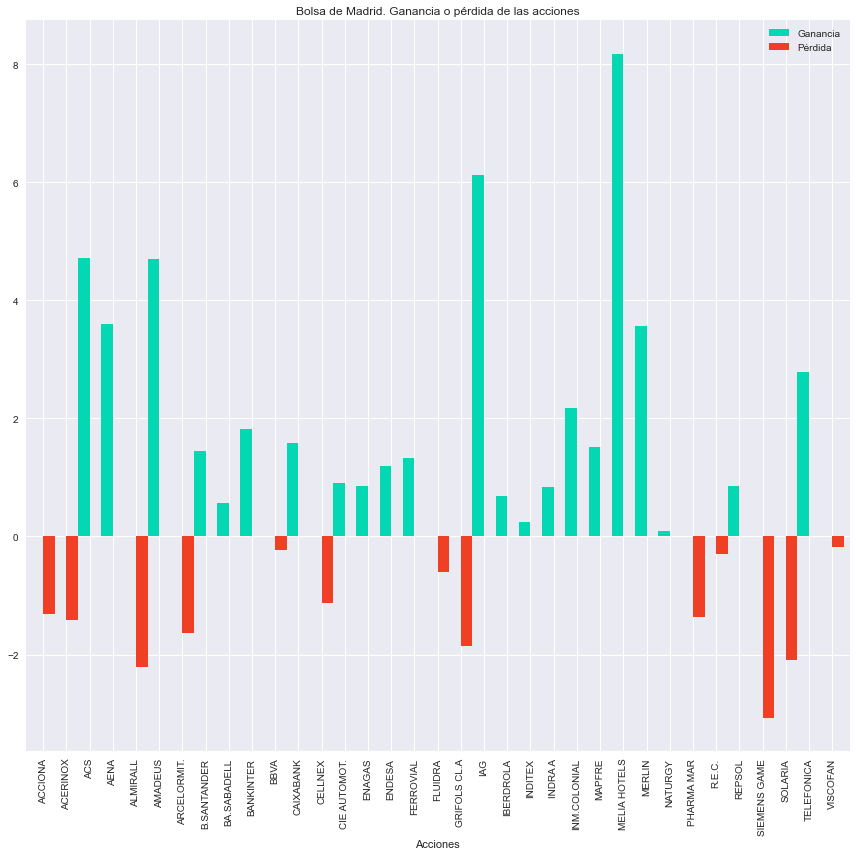

In [40]:
       
class bolsaMadrid(Origen):
    campo_nombre = 'Nombre'
    campo_valorMaximo = 'Máx'
    campo_valorMinimo = 'Mín'
    campo_UltimoPrecio = 'Últ'
    campo_cambio = '% Dif'
    campo_moneda = 'Moneda'
    campo_fecha = 'Fecha'
    campo_hora = 'Hora'
    
    def __init__(self):
        super().__init__()

    def actualizarBD(self):
        #Hacemos la consulta a la pagina y guardamos el contenido en una variable soup
        url_page = 'https://www.bolsamadrid.es/esp/aspx/Mercados/Precios.aspx?indice=ESI100000000'
        page = requests.get(url_page).text 
        soup = BeautifulSoup(page, "lxml")

        #Buscamos la tabla de donde obtener los datos
        tabla = soup.find('table', attrs={'id': 'ctl00_Contenido_tblAcciones'})

        #creamos una lista vacia que llenaremos con los datos de las tablas
        columnas = []

        #buscamos los encabezados de la tabla y los agregamos a la lista columnos (deberia ubicarse en la posicion 0)
        headers = []
        for th in tabla.find_all('th'):
            headers.append(th.text.replace('.',''))
        columnas.append(headers)

        for tr in tabla.find_all('tr'):
            fila = []
            for td in tr.find_all('td'):
                fila.append(td.text)
            if len(fila) > 0:
                columnas.append(fila)
                
        #creamos el dataframe usando la lista columnas,pasamos el contenido (de la posicion 1 en adelante), y lo encabezados en (posicion 0)
        df = pd.DataFrame(columnas[1:], columns=columnas[0])

        df=df.assign(Moneda=(headers[6])) #agregamos el campo moneda

        #Convertirmos a float
        df = self.__convertirAFloat(df)

        #Guardamos los datos en la base de datos
        self._guardarEnBD(df)
        
    def __convertirAFloat(self, df):
        df["% Dif"] = df["% Dif"].str.replace(",", ".").astype(float)
        df["Máx"] = df["Máx"].str.replace(",", ".").astype(float)
        df["Mín"] = df["Mín"].str.replace(",", ".").astype(float)
        df["Últ"] = df["Últ"].str.replace(",", ".").astype(float)
        return df

nombreDeAcciones =[
    'BBVA', "BBVA.MC",
    'ELE', "ELE.MC", 'ENDESA',
    'GRLS', "GRF.MC", 'GRIFOLS CL.A',
    'INDRA A', 'IDR',"IDR.MC",
    "REP.MC", 'REP','REPSOL'
    ]

bolsamadrid = bolsaMadrid()
bolsamadrid.actualizarBD()
print(bolsamadrid.filtrarAcciones(nombreDeAcciones))
#bolsamadrid.visualizarDF()
bolsamadrid.gananciaPerdidaAcciones(2)
bolsamadrid.graficarGananciaPerdida(titulo='Bolsa de Madrid. Ganancia o pérdida de las acciones', nombre='Ganan_perd_BolsaMadrid.png')
#accion = bolsamadrid.accion('BBVA')
#print(accion.mov) """

In [25]:
class yfinance(Origen):
    campo_nombre = 'Ticker'
    campo_valorMaximo = 'High'
    campo_valorMinimo = 'Low'
    campo_UltimoPrecio = 'Close'
    campo_cambio = 'Dif'
    campo_moneda = 'Moneda'
    campo_fecha = 'Fecha'
    campo_hora = 'Hora'
    
    def __init__(self):
        super().__init__()

    def actualizarBD(self, acciones):
        df_list = list()
        for accion in acciones:
            if not " " in accion and ".MC" in accion:
                data = yf.download(accion, group_by='ticker', period='1d')
                if not data.empty:
                    data['Ticker'] = accion
                    data['Dif'] = self.__calcularDiferencia(data['Open'], data['Close'])
                    df_list.append(data)

        if len(df_list) > 0:
            df = pd.concat(df_list)
            #agregamos moneda, fecha y hora
            df=df.assign(Moneda='Euro',Fecha=datetime.now().strftime('%d/%m/%Y'),Hora=datetime.now().strftime('%H:%M:%S'))
            self._guardarEnBD(df)
    
    def __calcularDiferencia(self, A, B):
        return (B*100)/A-100

yahooFinance = yfinance()
yahooFinance.actualizarBD(nombreDeAcciones)
#yahooFinance.visualizarBD()
#yahooFinance.visualizarDF()
yahooFinance.filtrarAcciones(nombreDeAcciones)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,symbol,max,min,ult,mov,moneda,fecha,hora,origen
0,BBVA.MC,6.107000,5.997,6.026,-0.033176,Euro,06/11/2021,17:25:04,yfinance
1,ELE.MC,20.200001,19.885,20.000,0.000000,Euro,06/11/2021,17:25:04,yfinance
2,GRF.MC,18.850000,18.160,18.500,-1.069523,Euro,06/11/2021,17:25:04,yfinance
3,IDR.MC,10.900000,10.640,10.780,1.030925,Euro,06/11/2021,17:25:04,yfinance
4,REP.MC,10.878000,10.584,10.812,0.952383,Euro,06/11/2021,17:25:04,yfinance



Acciones de mayor ganancia
    symbol    max     min     ult   mov moneda       fecha      hora    origen
27   ICAG   2.10   1.903   2.095  6.13    EUR  06/11/2021  17:25:54  investPy
30    AMA  62.39  57.389  61.830  5.12    EUR  06/11/2021  17:25:54  investPy

Acciones de mayor pérdida
    symbol     max     min   ult   mov moneda       fecha      hora    origen
10  SGREN  19.343  18.337  18.8 -3.14    EUR  06/11/2021  17:25:54  investPy
33   ROVI  63.800  56.300  56.9 -9.68    EUR  06/11/2021  17:25:54  investPy


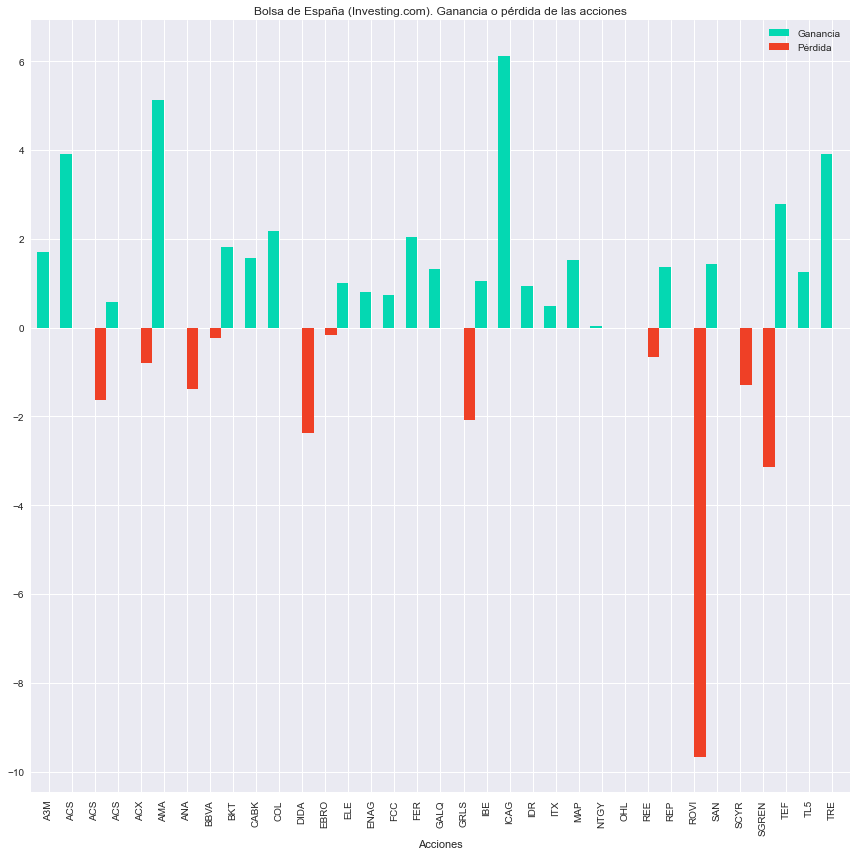

' invest.visualizarBD()\ninvest.visualizarDF()\n'

In [26]:
class investPy(Origen):
    
    campo_nombre = 'symbol'
    campo_valorMaximo = 'high'
    campo_valorMinimo = 'low'
    campo_UltimoPrecio = 'last'
    campo_cambio = 'GP'
    campo_moneda = 'currency'
    campo_fecha = 'Fecha'
    campo_hora = 'Hora'
    
    def __init__(self):
        super().__init__()


    def actualizarBD(self):
        df = investpy.stocks.get_stocks_overview(country='spain', as_json = False , n_results = 35)  
        df = self.__porcentajeCambio(df)
        #cambiar la columna a numérica
        df['GP'] = df['GP'].apply(pd.to_numeric)
        df=df.assign(Moneda='Euro',Fecha=datetime.now().strftime('%d/%m/%Y'),Hora=datetime.now().strftime('%H:%M:%S'))
        self._guardarEnBD(df)
    
    def __porcentajeCambio(self, df):
        return df.join(df['change_percentage'].str.partition('%')[[0, 1]]).rename({0: 'GP', 1: '%'}, axis=1)

invest = investPy()
invest.actualizarBD()
invest.gananciaPerdidaAcciones(2)
invest.graficarGananciaPerdida(titulo='Bolsa de España (Investing.com). Ganancia o pérdida de las acciones', nombre='Ganan_perd_Investpy.png')
""" invest.visualizarBD()
invest.visualizarDF()
""" 



In [114]:
class Cotizaciones():

    def __init__(self, acciones, mercados):
        self.acciones = acciones
        self.mercados = mercados
       
    def juntarDBS(self):
        df = pd.DataFrame()
        for mercado in self.mercados:
            df = pd.concat([df, mercado.filtrarAcciones(self.acciones)], axis=0)
        return df
    

    def graficarComparacion(self,titulo,nombre):
        df = self.juntarDBS()
        comparar = df.groupby(['symbol', 'origen']).mean()["ult"]
        # genera el gráfico:
        comparar.plot(kind="bar",width=0.9, color=["#06C2A6","#FF7960","#DBB40C"], figsize=(8,8))
        plt.style.use('seaborn')
        plt.tight_layout()  # tip(!)
        plt.title(titulo) #título del grafico 
        plt.xlabel('Acciones') #título del eje de las x
        plt.savefig(nombre, bbox_inches='tight') #guardamos el gráfico, 'tight' para guardarlo completo [parámetro: nombre]

    #otra forma de mostrar el gráfico (pero no quedaría bien)
    #me parece que pega las columnas que tienen el mismo valor
    def graficarComparacion2(self,titulo,nombre):
        df = self.juntarDBS()
        comparar = df.groupby(['symbol', 'origen']).mean()["ult"].unstack()
        # genera el gráfico:
        comparar.plot(kind="bar",width=1, color=["#06C2A6","#FF7960","#DBB40C"], figsize=(8,8))
        plt.tight_layout()  # tip(!)
        plt.title(titulo) #título del grafico 
        plt.xlabel('Acciones') #título del eje de las x
        plt.savefig(nombre, bbox_inches='tight') 

         symbol        max     min     ult       mov              moneda  \
0          BBVA   6.107000   5.997   6.026 -0.230000  Efectivo (miles €)   
1        ENDESA  20.200000  19.885  20.000  1.190000  Efectivo (miles €)   
2  GRIFOLS CL.A  18.850000  18.160  18.500 -1.860000  Efectivo (miles €)   
3       INDRA A  10.900000  10.640  10.780  0.840000  Efectivo (miles €)   
4        REPSOL  10.878000  10.584  10.812  0.860000  Efectivo (miles €)   
0       BBVA.MC   6.107000   5.997   6.026 -0.033176                Euro   
1        ELE.MC  20.200001  19.885  20.000  0.000000                Euro   
2        GRF.MC  18.850000  18.160  18.500 -1.069523                Euro   
3        IDR.MC  10.900000  10.640  10.780  1.030925                Euro   
4        REP.MC  10.878000  10.584  10.812  0.952383                Euro   
0          BBVA   6.107000   5.997   6.026 -0.230000                 EUR   
1          GRLS  18.805000  18.185  18.480 -2.070000                 EUR   
2           

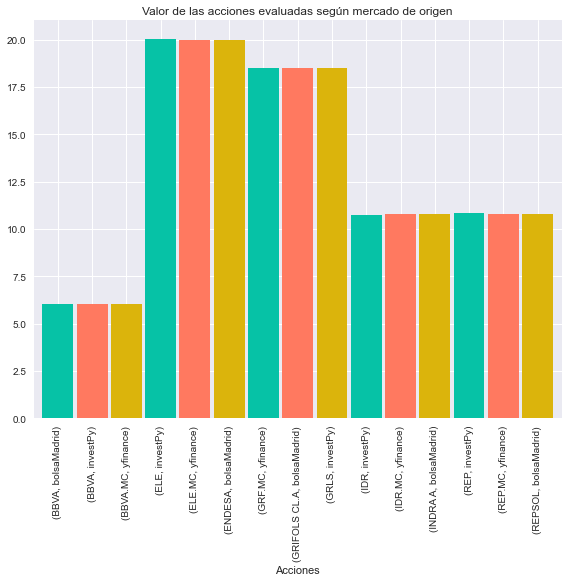

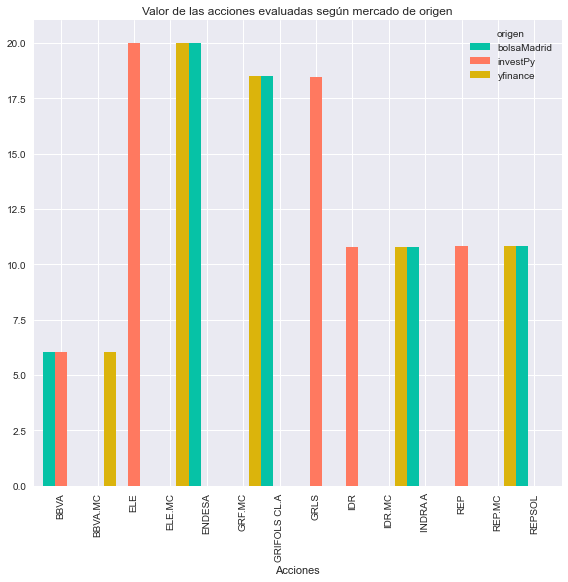

In [115]:

cotizaciones = Cotizaciones(nombreDeAcciones, [bolsamadrid, yahooFinance, invest])
print(cotizaciones.juntarDBS())
cotizaciones.graficarComparacion('Valor de las acciones evaluadas según mercado de origen','comparacionAccionesSegunMercado.png')
cotizaciones.graficarComparacion2('Valor de las acciones evaluadas según mercado de origen','comparacionAccionesSegunMercado2.png')